## Imports

In [14]:
import os
import torch
import torchaudio
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram


## Loading Data

- `train_audio/`: short recordings of individual species with labels - *supervised learning*
- `train_soundscapes/`: long recordings without labels - *unsupervised learning*
- `train.csv`: metadata for the training audio

One thing that can be done is to map species name to label index.

In [15]:
# loading metadata

metadata_path = "data/train.csv"

metadata = pd.read_csv(metadata_path)
metadata.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


## Create a Dataset Class

In [16]:
class AudioDataset(Dataset):
    def __init__(self, metadata_csv, audio_dir, transform=None):
        """
        metadata_csv: path to train.csv
        audio_dir: path to train_audio/
        transform: transform for waveform
        """
        self.data = pd.read_csv(metadata_csv)
        self.audio_dir = audio_dir
        self.transform = transform

        # sort by alphabetical order, then map species name to label index
        self.classes = sorted(self.data["primary_label"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get metadata row of specified index
        row = self.data.iloc[idx]

        # construct path to audio file
        audio_path = os.path.join(self.audio_dir, row["filename"])
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
        except:
            print(f"Error loading {audio_path}")
            return torch.zeros(1, 16000), -1 # dummy data if missing file

        # apply any transformation if specified
        if self.transform:
            waveform = self.transform(waveform)

        # get label
        label = self.class_to_idx[row["primary_label"]]

        return waveform, label

### TASK

find out more about `n_mels`:
- represents the frequency resolution of spectrogram along y-axis
- higher value: more detail but increases computation cost + complexity
- lower value: reduces dimensionality, can help to prevent overfitting

i picked 32 as a "happy medium"

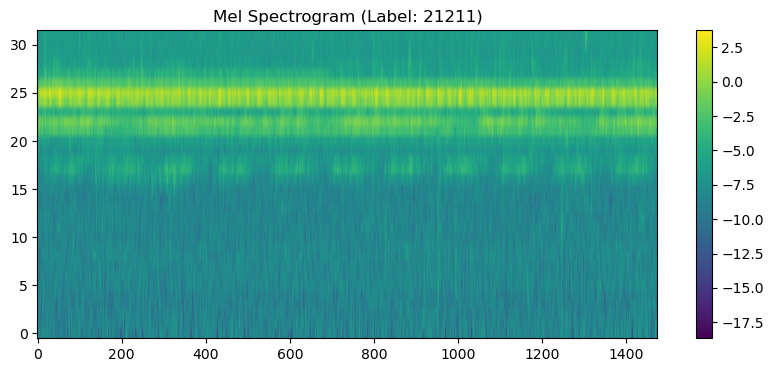

In [17]:
# define transform
transform = MelSpectrogram(sample_rate=32000, n_mels=32)

# initialize dataset & dataloader
dataset = AudioDataset(metadata_csv="data/train.csv", audio_dir="data/train_audio", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# visualize sample
waveform, label = dataset[69]
# squeeze first dimension to convert from (1, 32, 15817) to (32, 15817)
mel_spec = waveform.squeeze(0).log2().detach().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec, aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram (Label: {dataset.classes[label]})")
plt.colorbar()
plt.show()